In [15]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

sys.path.append(os.path.dirname(os.path.abspath(os.getcwd())) + "/..")
if os.getcwd().endswith("Topic2"):
    os.chdir("..")
    print(f"Changed to {os.getcwd()}")

from codebase import(
    transport_modes, 
    trip_motives, 
    transport_mode_col, 
    IGNORE_RULES, 
    apply_ignore_rules,
    id_col,
    get_feature_importances,
    save_features_per_num, 
    load_features_per_num,
    run_transferable_classification
    )

from codebase.data.load_odin import load_odin
run_ML = False
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
odin_df = load_odin()

[INFO] Loading ODiN data for years: [2019, 2020, 2021, 2022, 2023]
[INFO] Reading file: data\OdiN 2019-2023\OdiN 2019\ODiN2019_Databestand_v2.0.csv
Loaded file from CSV
[INFO] Loaded 179,091 rows for 2019
[INFO] Reading file: data\OdiN 2019-2023\OdiN 2020\ODiN2020_Databestand_v2.0.csv
Loaded file from CSV
[INFO] Loaded 176,729 rows for 2020
[INFO] Reading file: data\OdiN 2019-2023\OdiN 2021\ODiN2021_Databestand.csv
Loaded file from CSV
[INFO] Loaded 196,768 rows for 2021
[INFO] Reading file: data\OdiN 2019-2023\OdiN 2022\ODiN2022_Databestand.csv
Loaded file from CSV
[INFO] Loaded 200,054 rows for 2022
[INFO] Reading file: data\OdiN 2019-2023\OdiN 2023\ODiN2023_Databestand.csv
Loaded file from CSV
[INFO] Loaded 211,991 rows for 2023
[INFO] Total rows after concatenation: 964,633
[FILTER] Only-one-mode trips: 180,750 rows (filtered 783,883)
[FILTER] After ignore rules: 180,750 rows (filtered 0)
[DONE] Final dataset shape: (180750, 251)


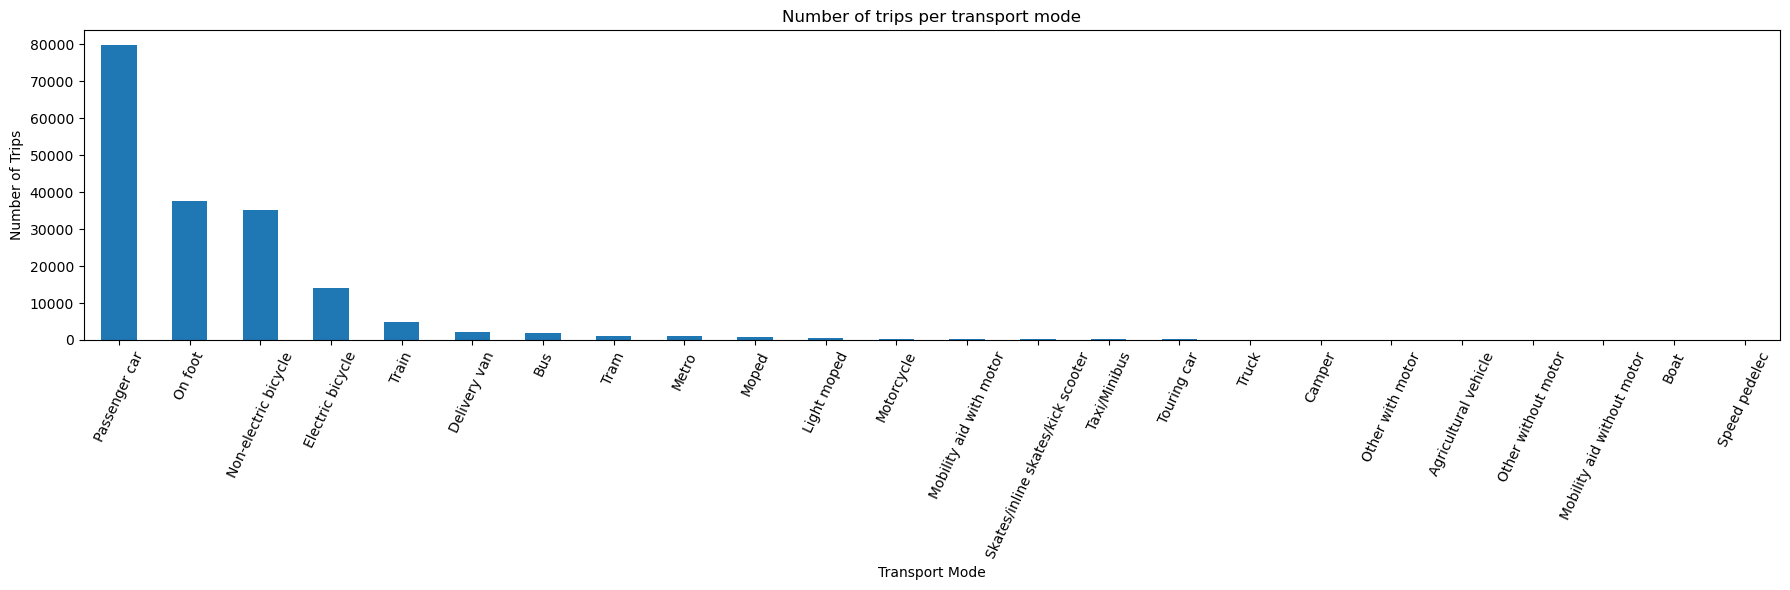

In [17]:
# Create a histogram for the number of trips for each transport mode and translate to 
ax = odin_df[transport_mode_col].value_counts().plot(kind="bar", title="Number of trips per transport mode", figsize=(18, 6))

ax.set_xticklabels([transport_modes.get(int(float(label.get_text())), label.get_text()) for label in ax.get_xticklabels()], rotation=65)

plt.xlabel("Transport Mode")
plt.ylabel("Number of Trips")
plt.tight_layout()
plt.savefig("graphics/transport_modes_histogram.png", dpi=300)
plt.show()

Now a classifier that classifies what mode of transport was used

In [ ]:
from codebase import (run_multiclass_classification,
                      distance_col, 
                      origin_col, 
                      province_codes, 
                      level_mapping_suffix, 
                      age_col, 
                      transport_mode_col, 
                      motive_col, 
                      urbanness_col,
                      categorical_cols)


df_multiclass = odin_df[odin_df[transport_mode_col] != odin_df[transport_mode_col].max()]
motives=None
origins=None#[7, 8, ]
location_level=2
origin_str = ', '.join(province_codes[code] for code in origins) if origins is not None else "NL"
motive_str = ', '.join(trip_motives[motive] for motive in motives) if motives is not None else "all motives"

pipeline_all, (X_train_all, _, _, _), accuracy = run_multiclass_classification(
    df_multiclass,
    test_size=0.2,
    destinations=None,
    origins=origins,
    location_level=location_level,
    categorical_features=categorical_cols,
    motives=motives,
    plot=True,
    savename=f"graphics/classification_results/multiclass/{level_mapping_suffix[location_level]}/full",
    plot_title=f"Confusion Matrix for {origin_str} and {motive_str}",
    verbose=True,
)

Common labels: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:701: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmin(X, axis=axis))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:718: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmax(X, axis=axis))
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    3.4s


In [ ]:
get_feature_importances(pipeline_all["model"].feature_importances_, top_n_for_plot=40, column_names=X_train_all.columns, savename=f"graphics/classification_results/multiclass/feature_importances_all.png")

In [ ]:
from codebase import urbanness_col, motive_col

age_range = (0, np.inf)
vehicles_to_include = [1, 7, 8, 9, ]

df_less_vehicles = df_multiclass[df_multiclass[transport_mode_col].isin(vehicles_to_include)]
df_less_vehicles: pd.DataFrame = df_less_vehicles[(df_less_vehicles[age_col] < age_range[1]) & (df_less_vehicles[age_col] > age_range[0])]

In [ ]:
location_level=2
origin_str = ', '.join(province_codes[code] for code in origins) if origins is not None else "NL"
motive_str = ', '.join(trip_motives[motive] for motive in motives) if motives is not None else "all motives"

pipeline_less, (X_train_less, _, _, _), accuracy = run_multiclass_classification(
    df_less_vehicles,
    test_size=0.2,
    destinations=None,
    origins=origins,
    location_level=location_level,
    categorical_features=categorical_cols,
    motives=motives,
    plot=True,
    savename=f"graphics/classification_results/multiclass/{level_mapping_suffix[location_level]}/less_vehicles",
    plot_title=f"Confusion Matrix for {origin_str} and {motive_str}",
)

In [ ]:
grouped_importances_less = get_feature_importances(pipeline_less["model"].feature_importances_, column_names=X_train_less.columns, top_n_for_plot=40, savename=f"graphics/classification_results/multiclass/feature_importances_less_vehicles.png")

Now keep the top N

In [ ]:
"Hvm" in df_less_vehicles.columns

Decide whether or not to run the random forest loop with decreasing number of features present

In [ ]:
overwrite = False

feature_savename = "data/features_per_num.pkl"
accs_savename = "data/accuracies_per_num.pkl"

In [ ]:
if os.path.exists(feature_savename) and not overwrite:
    features_per_num, accs = load_features_per_num(feature_savename, accs_savename)
    nums = list(features_per_num.keys())
else:
    prev_grouped_importances = grouped_importances_less

    nums = [200, 100, 50, 25, 15, 10, 8, 5, 4, 3, 2, 1]
    accs = []
    features_per_num = dict()

    for num_keep in nums:
        prev_grouped_importances = prev_grouped_importances.sort_values(ascending=False)[:num_keep]

        cols_to_drop = [col for col in df_less_vehicles.columns if col not in list(prev_grouped_importances.index) + [transport_mode_col, id_col]]
        df_keep_loop = df_less_vehicles.drop(columns=cols_to_drop)
        print(f"Keeping {len(df_keep_loop.columns)} columns after dropping {len(cols_to_drop)} columns.")

        pipeline_keep_loop, (X_train, _, _, _), accuracy = run_multiclass_classification(
            df_keep_loop,
            test_size=0.2,
            destinations=None,
            origins=origins,
            location_level=location_level,
            categorical_features=categorical_cols,
            motives=motives,
            plot=True,
            savename=f"graphics/classification_results/multiclass/{level_mapping_suffix[location_level]}/less_vehicles_{num_keep}",
            plot_title=f"Confusion Matrix for {origin_str} and {motive_str} using {num_keep} features",
            verbose=True,
        )


        prev_grouped_importances = get_feature_importances(
            pipeline_keep_loop["model"].feature_importances_, 
            column_names=X_train.columns, 
            top_n_for_plot=40, 
            savename=f"graphics/classification_results/multiclass/feature_importances_less_vehicles_{num_keep}.png"
        )
        accs.append(accuracy)

        features_per_num[num_keep] = prev_grouped_importances
    save_features_per_num(features_per_num, accs, feature_savename, accs_savename)

In [ ]:
plt.figure(figsize=(18, 4))
plt.plot(nums, accs, marker='o')
plt.title("Accuracy vs Number of Features Kept")
plt.xlabel("Number of Features Kept")
plt.ylabel("Accuracy")
# plt.xscale('log')
plt.xticks(nums)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.grid(True)
plt.savefig("graphics/classification_results/multiclass/accuracy_vs_num_features.png", dpi=300)
plt.show()

In [ ]:
num_to_replicate = 10

# categorical_cols_for_small = [
#     urbanness_col, 
#     age_col,
#     distance_col,
#     motive_col,
#     "KAfstV",
#     "Doel"
# ] 

cols_to_keep = features_per_num[num_to_replicate].index.to_list() + [id_col]
cols_to_drop = [col for col in df_less_vehicles.columns if col not in cols_to_keep + [transport_mode_col]]

pipeline_transferable, (X_train, _, _, _), accuracy = run_multiclass_classification(
    df_less_vehicles,
    test_size=0.2,
    destinations=None,
    origins=origins,
    location_level=location_level,
    categorical_features=categorical_cols,
    drop_cols=cols_to_drop,
    motives=motives,
    plot=True,
    savename=f"graphics/classification_results/multiclass/transferable_forest_{num_to_replicate}",
    plot_title=f"Confusion Matrix for {origin_str} and {motive_str}",
)

In [ ]:
from codebase import run_transferable_classification
cols_for_transferable = features_per_num[num_to_replicate].index.to_list()

df_with_probs = run_transferable_classification(
    odin_df=odin_df,
    pipeline_transferable=pipeline_transferable,
    cols_for_transferable=cols_for_transferable,
    necessary_columns=X_train.columns,
    col_car_pred = "willingness_to_car_pred",
    col_cycle_pred = "willingness_to_cycle_pred",
    col_ebike_pred = "willingness_to_ebike_pred",
    col_walk_pred = "willingness_to_walk_pred",
    threshold_datapoints=50,
    overwrite_existing=False
)

In [ ]:
X_train[X_train.isna()]

In [ ]:
odin_df[odin_df.notna()]

In [ ]:
no_na_cols = odin_df.dropna(axis=1).columns.to_list()
print([col for col in cols_for_transferable if col in no_na_cols])